In [2]:
# Imports
from __future__ import print_function
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

from helpers.process_results import get_results
from helpers.process_training import get_summaries

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# Load images
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Basic summary
print('Size of training dataset:', X_train.shape[0])
print('Size of testing dataset:', X_test.shape[0])
n_classes = np.unique(y_train).size
print('Number of classes in training:', n_classes)
print('Number of classes in testing:', np.unique(y_test).size)
print('Image array shape:', X_train[0].shape)

Size of training dataset: 50000
Size of testing dataset: 10000
Number of classes in training: 10
Number of classes in testing: 10
Image array shape: (32, 32, 3)


# Dataset exploration

## Class distribution

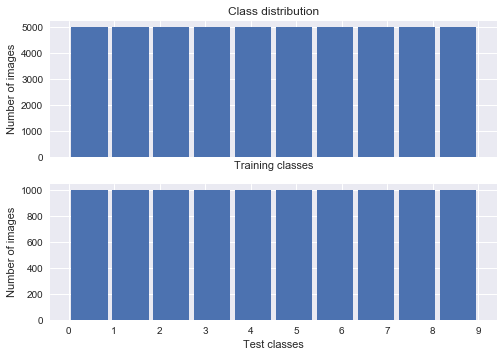

In [4]:
# Display class distribution
plt.figure(figsize=(14, 7))
f, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.hist(y_train, bins=n_classes, rwidth=0.9)
ax1.set_xlabel('Training classes')
ax1.set_ylabel('Number of images')
ax1.set_title('Class distribution')

ax2.hist(y_test, bins=n_classes, rwidth=0.9)
ax2.set_xlabel('Test classes')
ax2.set_ylabel('Number of images')
plt.xticks(range(n_classes))
plt.show()

## Visualize examples

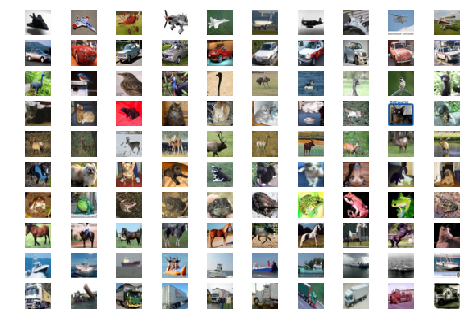

In [5]:
# Display example images
n_images = 10
f, axes = plt.subplots(n_classes, n_images)
for img_class in range(n_classes):
    imgs = X_train[y_train.flatten() == img_class][:n_images]
    for i, img in enumerate(imgs):
        ax = axes[img_class, i]
        ax.axis('off')
        ax.imshow(img.squeeze())
plt.show()

# Training evaluation

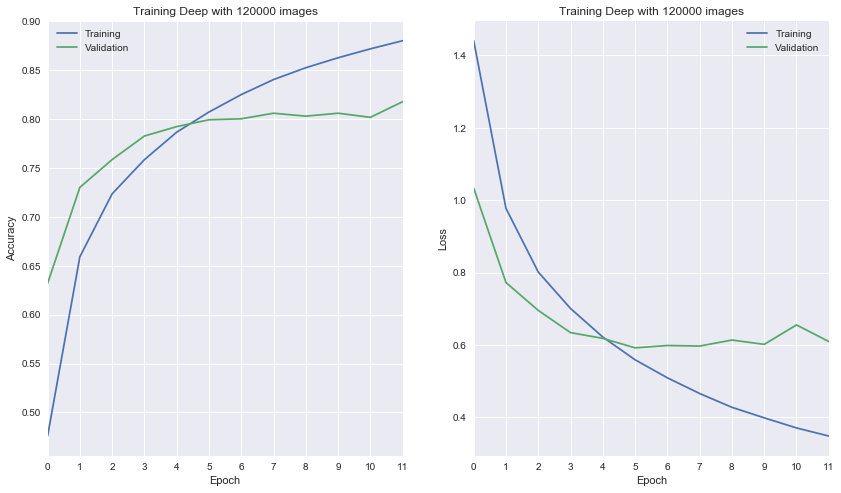

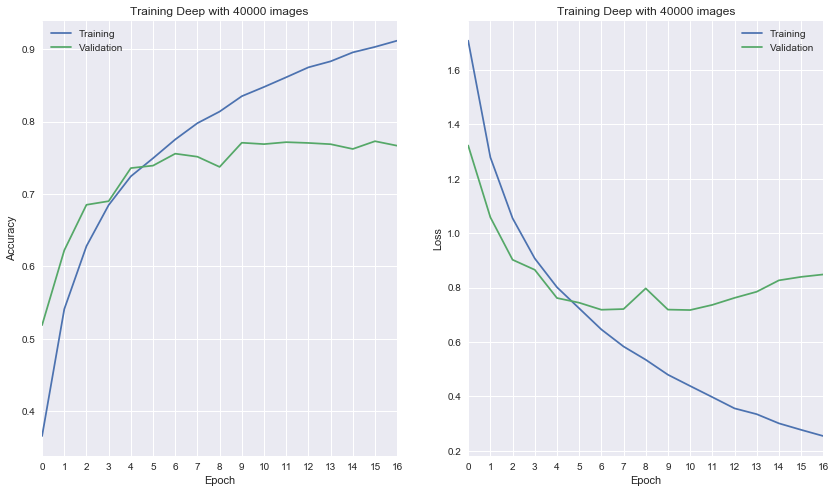

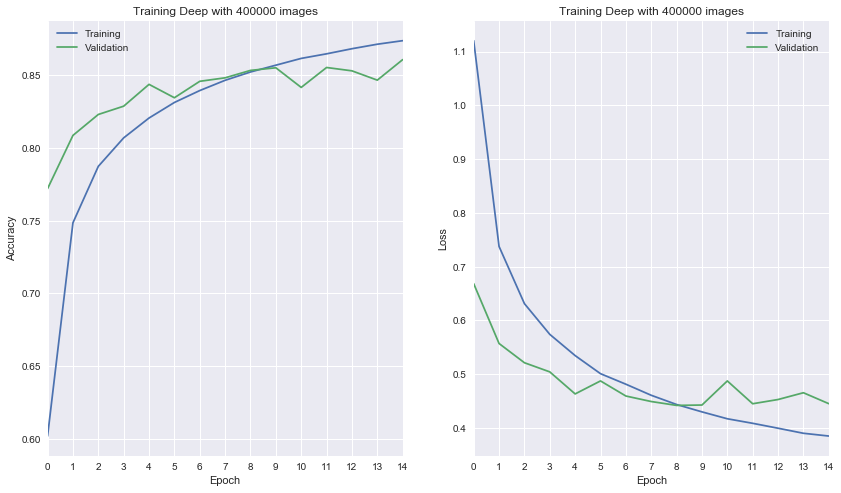

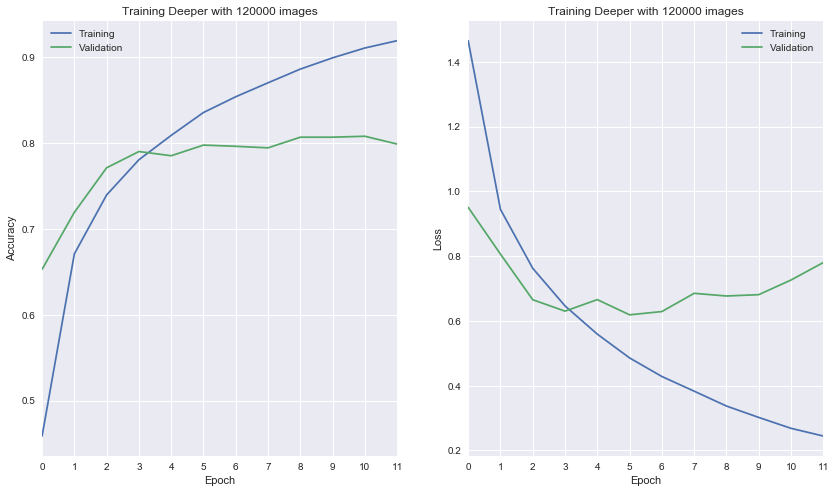

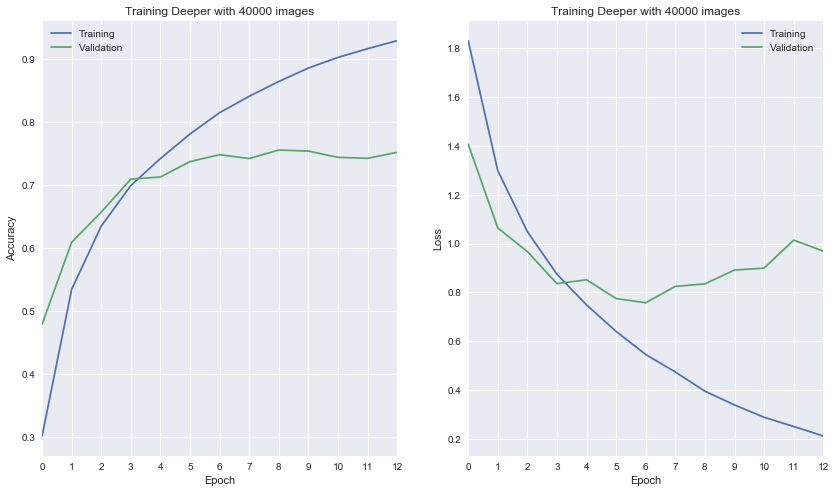

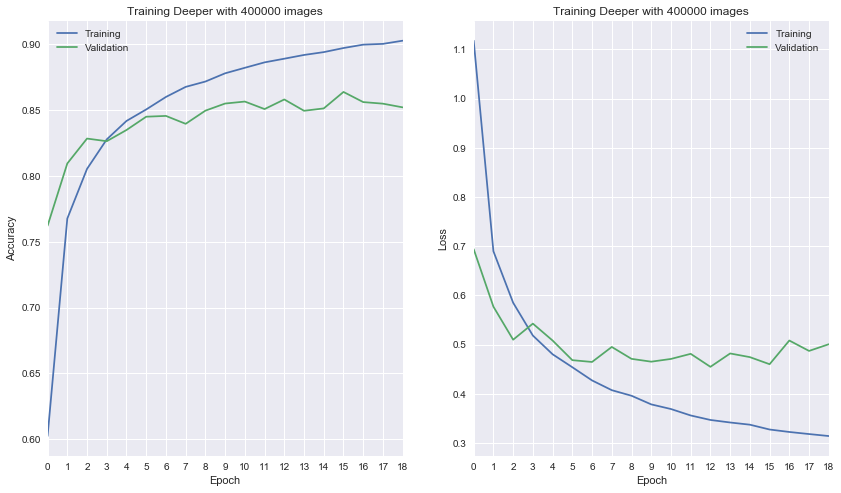

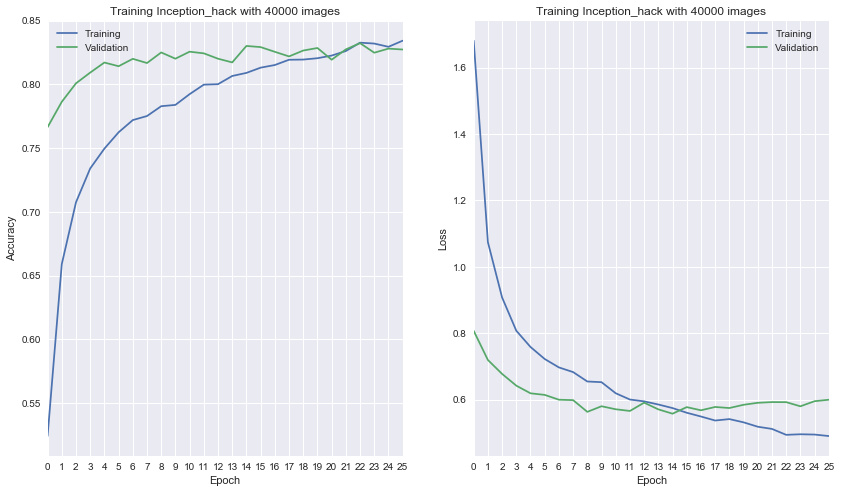

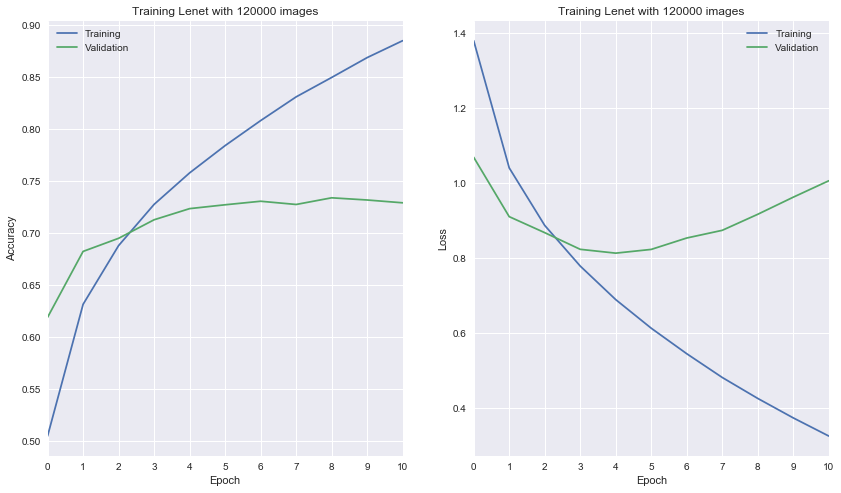

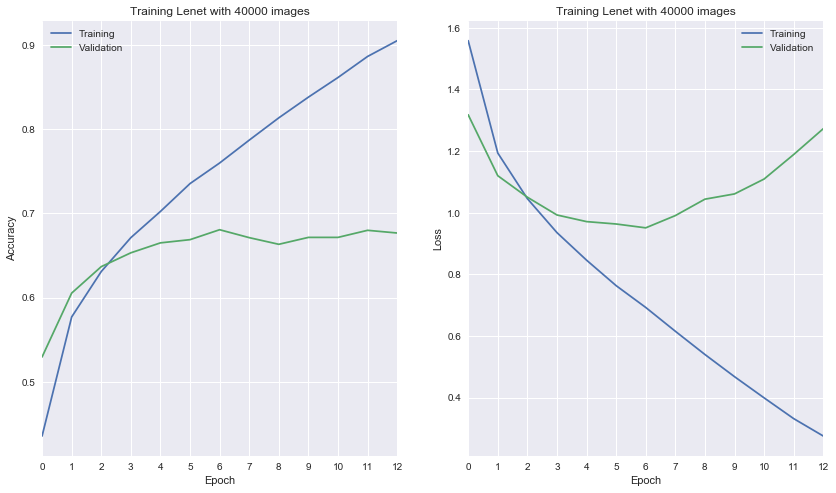

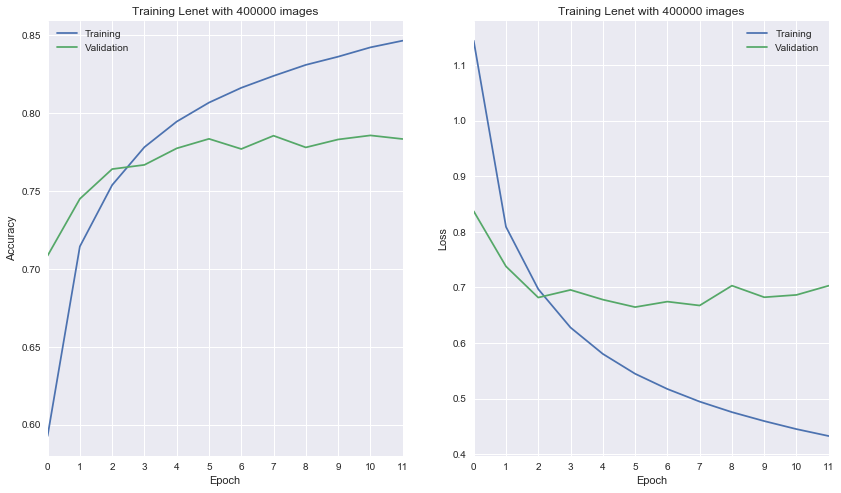

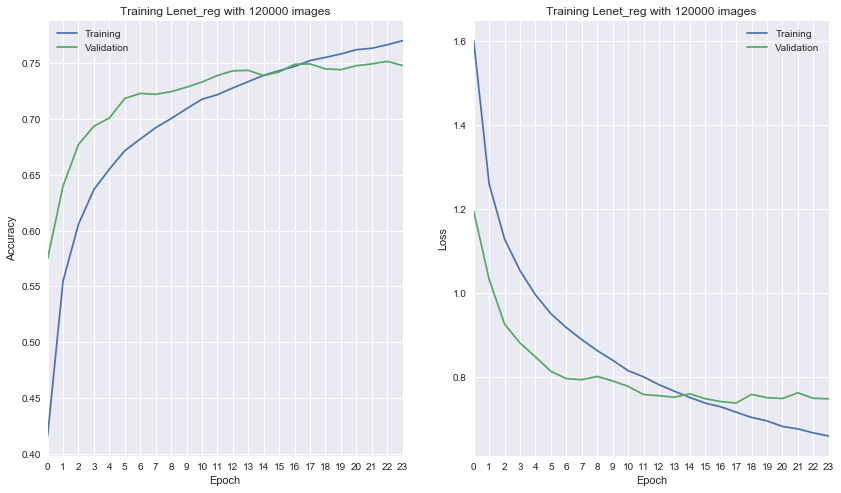

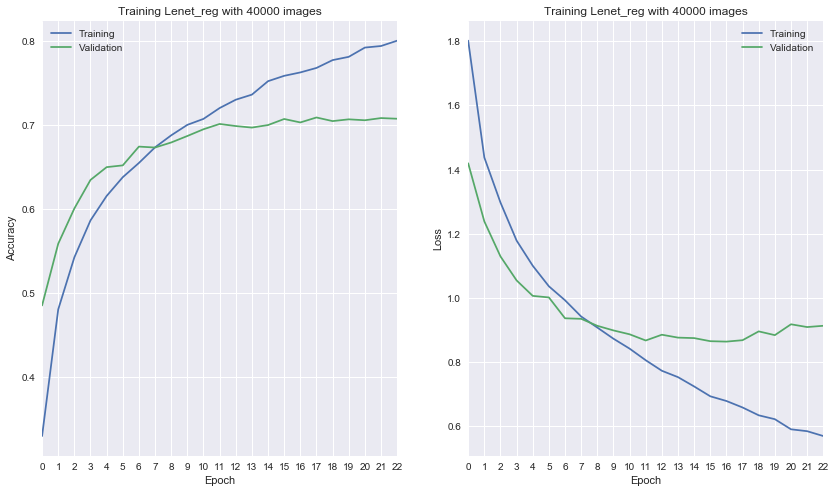

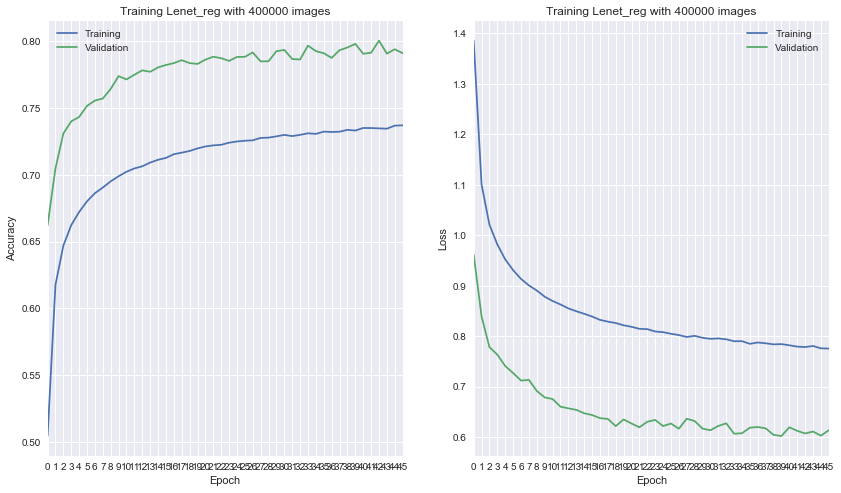

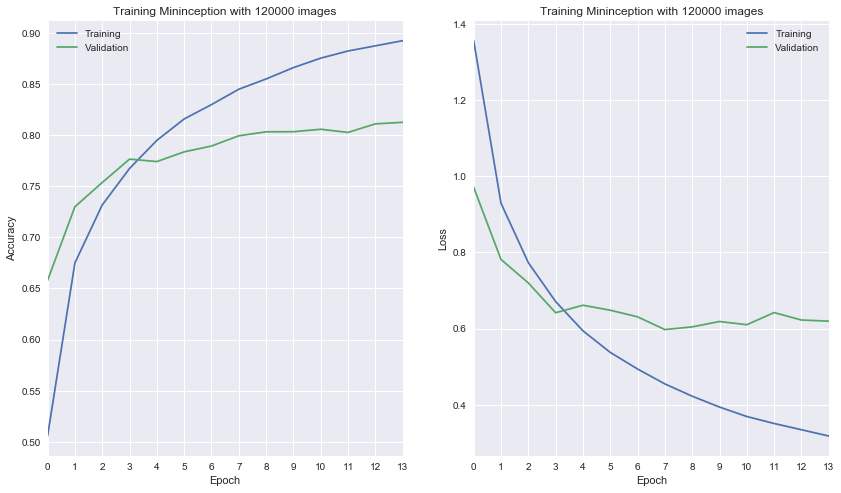

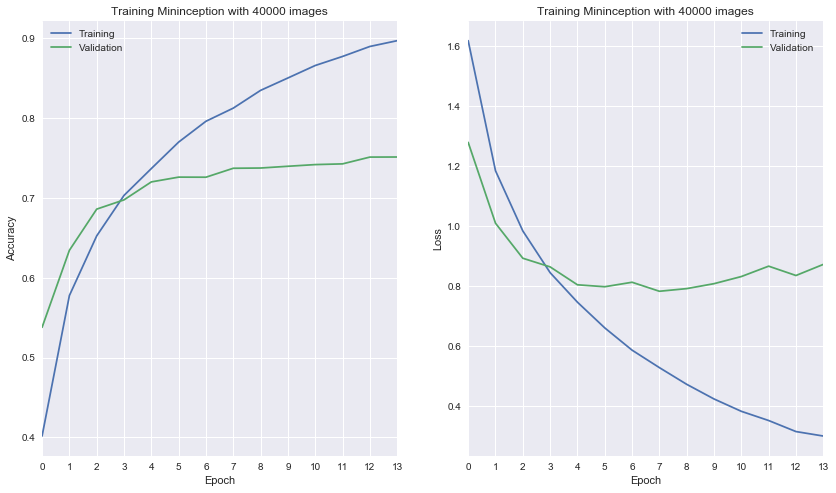

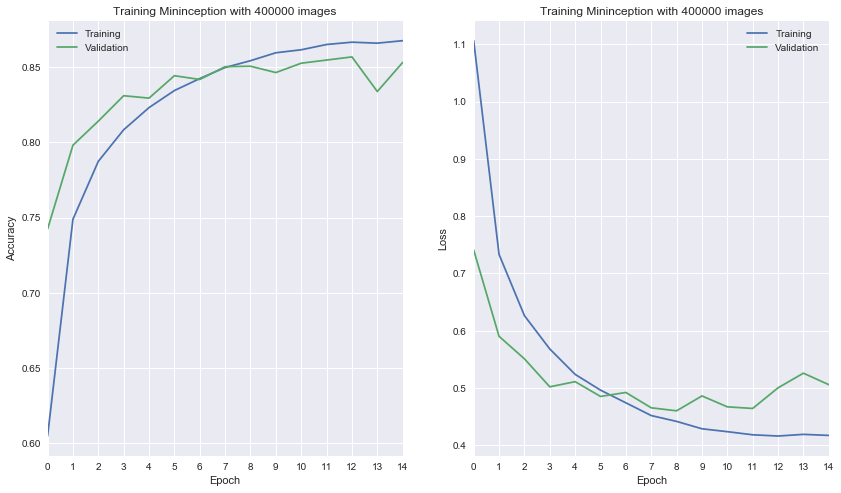

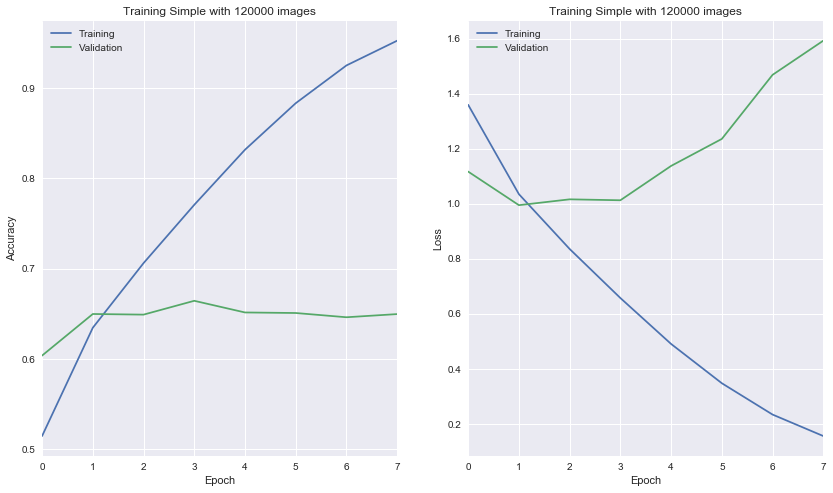

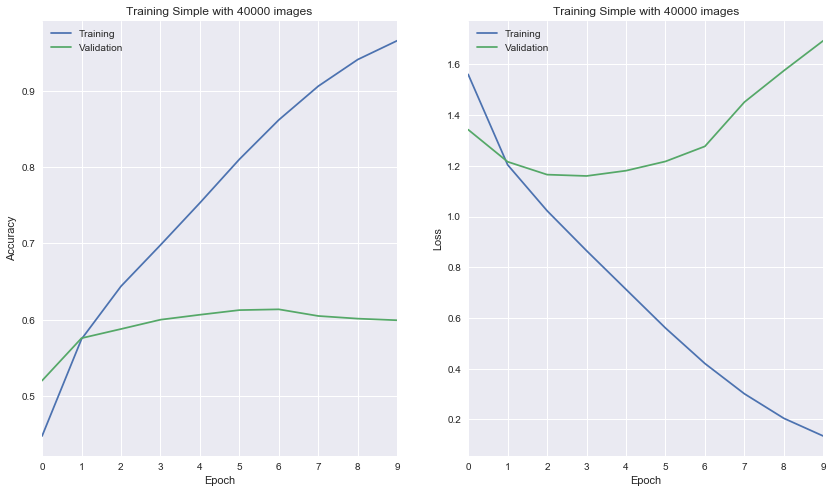

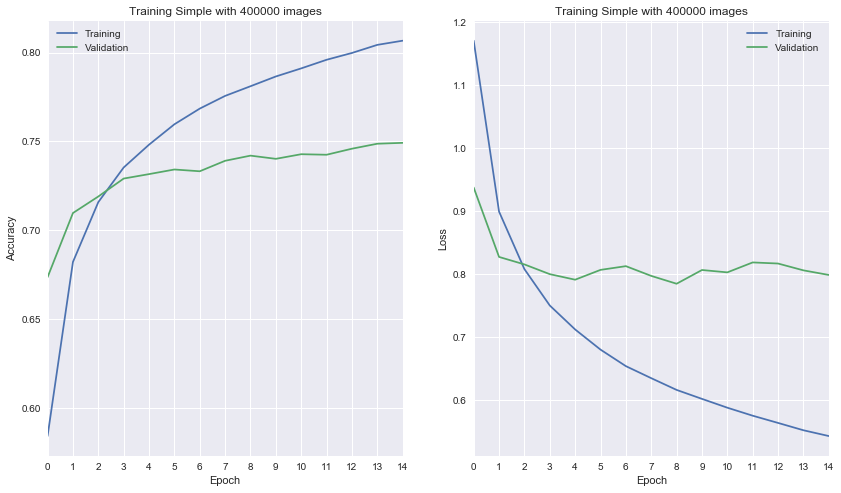

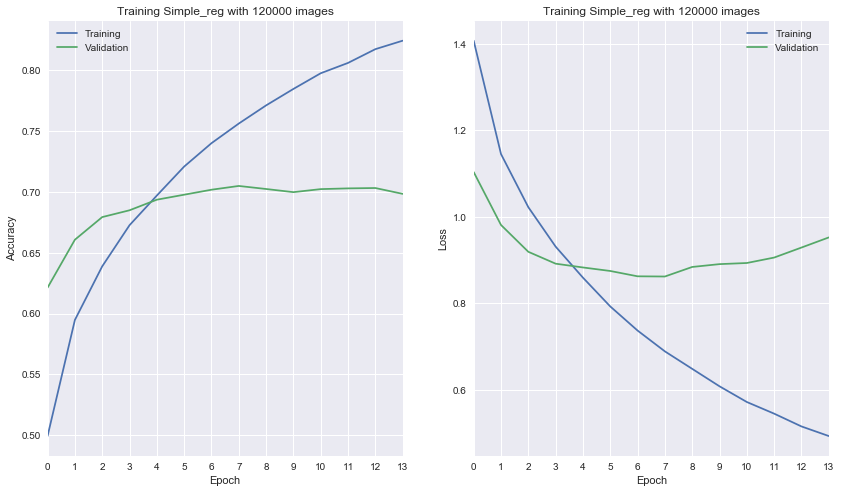

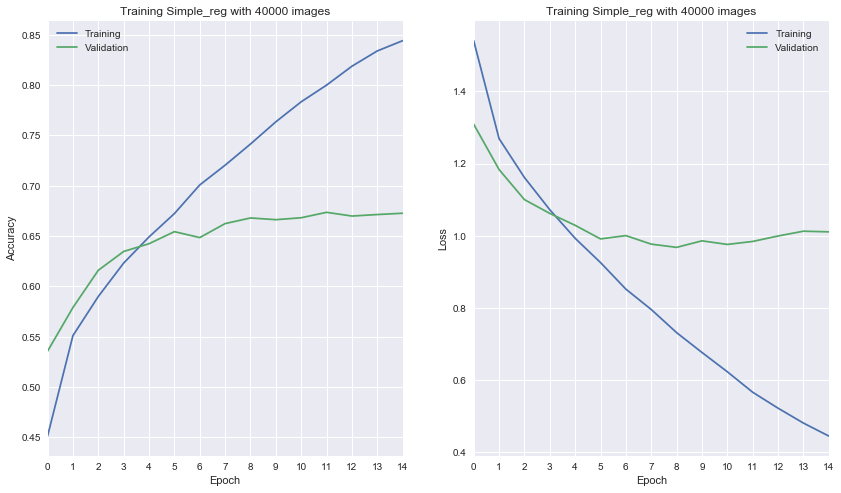

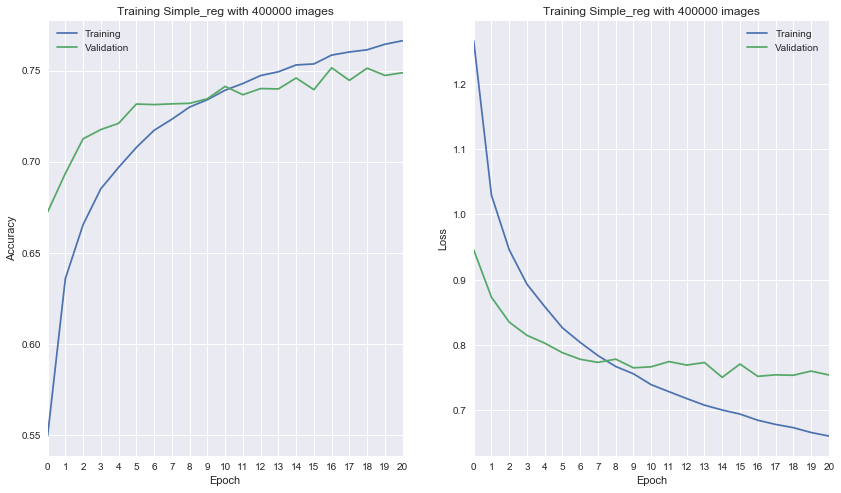

In [6]:
# Show training and validation evolution during training
training_data = get_summaries()
for _, group in training_data.groupby(['model', 'size']):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
    model, size = group['model'].unique()[0], group['size'].unique()[0]

    # Accuracy
    group[['acc', 'val_acc']].plot(ax=ax1, xticks=group['epoch'], use_index=False)
    ax1.set_title('Training {} with {} images'.format(model.capitalize(), size))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])
    
    # Loss
    group[['loss', 'val_loss']].plot(ax=ax2, xticks=group['epoch'], use_index=False)
    ax2.set_title('Training {} with {} images'.format(model.capitalize(), size))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])

    # Show
    plt.show()

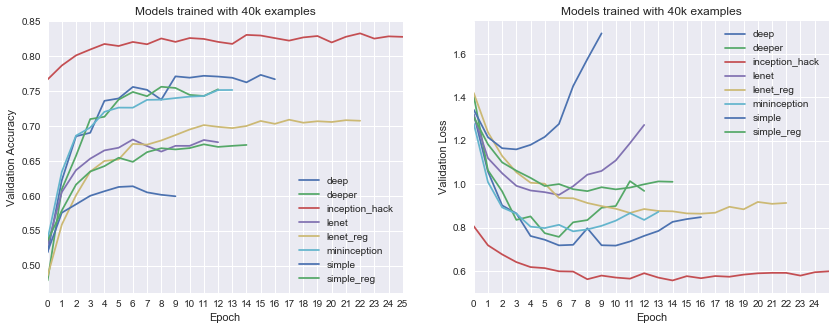

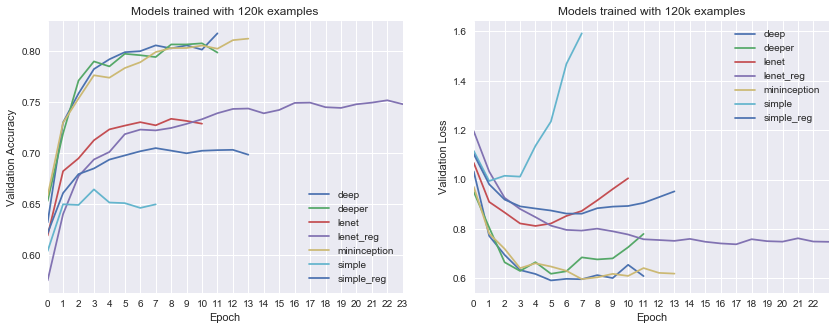

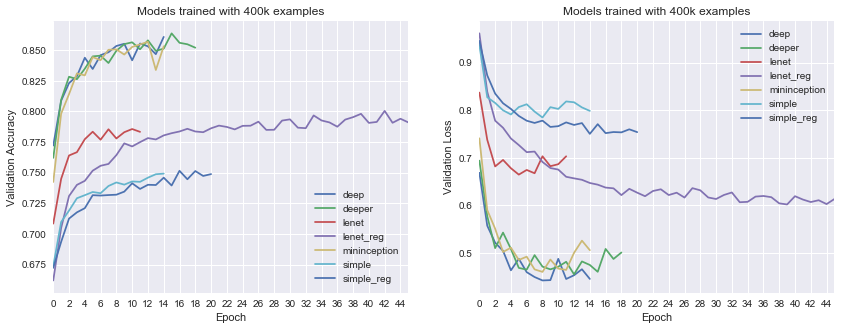

In [7]:
# Compare evolution of training
for size in ['40000', '120000', '400000']:
    group = training_data[training_data['size'] == size].groupby(['model'])
    max_epochs = group['epoch'].max().max()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    # Plot accuracy
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation Accuracy')
    ax1.set_title('Models trained with {}k examples'.format(int(size)/1000))
    ax1.set_xticks(range(0, max_epochs + 1, 1 if max_epochs < 30 else 2))
    group['val_acc'].plot(ax=ax1, use_index=False, legend=group['model'])
    
    # Plot loss
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Models trained with {}k examples'.format(int(size)/1000))
    ax2.set_xticks(range(0, max_epochs, 1 if max_epochs < 40 else 2))
    group['val_loss'].plot(ax=ax2, use_index=False, legend=group['model'])
    
    # Show
    plt.show()

# Results evaluation
## Accuracy

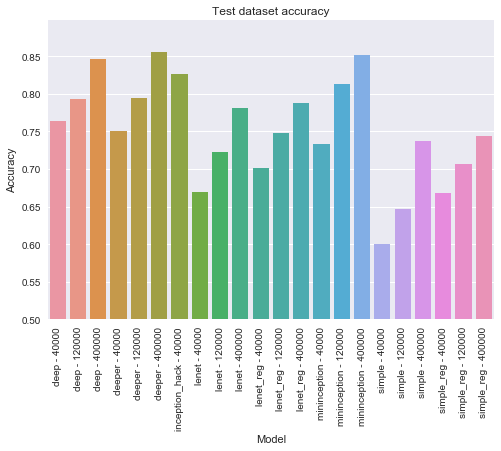

In [8]:
# Add pretrained inception
results = get_results()
# hack = pd.read_json('hack/output/hack_40000.json')
# hack['model'] = 'inception_v3'
# hack['size'] = 40000
# results = results.append(hack.loc[0], ignore_index=True).drop('history', 1)

# Plot comparision
groups = results.groupby(['model', 'size'])['test_accuracy'].sum()
sns.barplot(
    [' - '.join(map(str, i)) for i in groups.index],
    groups.values)
plt.xticks(rotation=90)
plt.ylim(0.5)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test dataset accuracy')
plt.show()

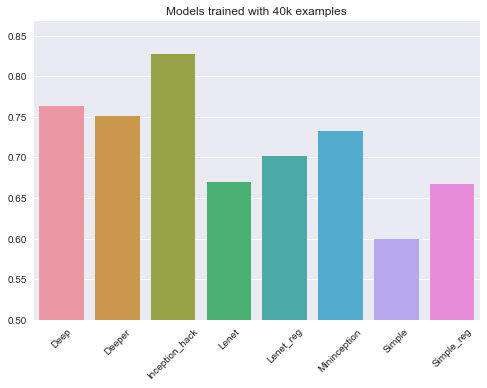

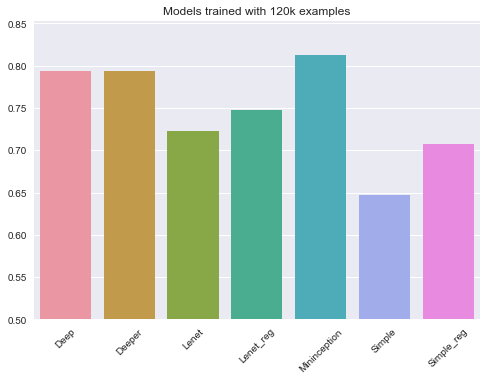

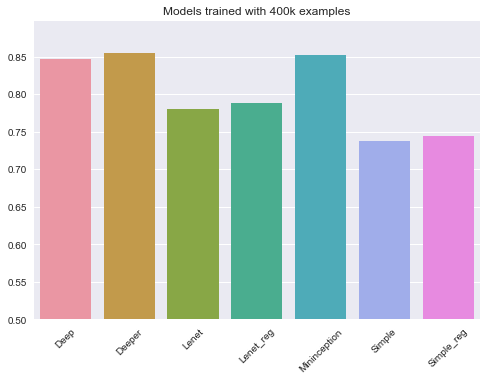

In [9]:
for size in [40000, 120000, 400000]:
    groups = results[results['size'] == size].groupby(['model', 'size'], squeeze=True)['test_accuracy'].sum()
    sns.barplot(
        [i[0].capitalize() for i in groups.index],
        groups.values)
    plt.title('Models trained with {}k examples'.format(size / 1000))
    plt.xticks(rotation=45)
    plt.ylim(0.5)
    plt.show()

## Confusion matrix

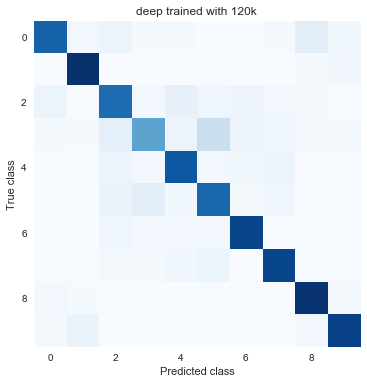

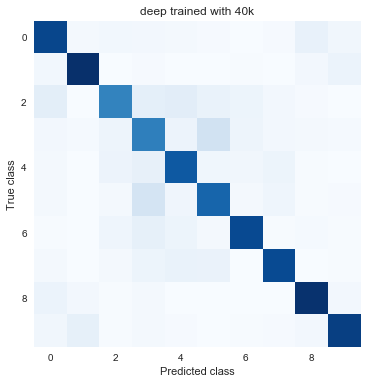

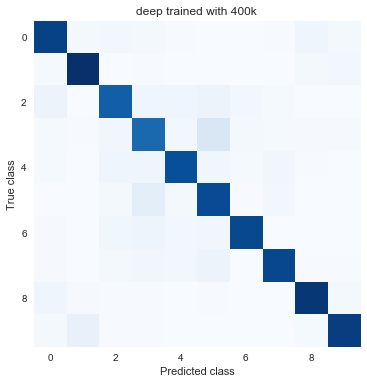

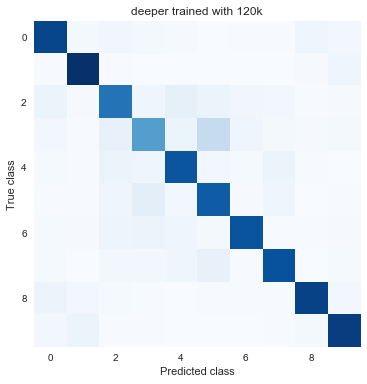

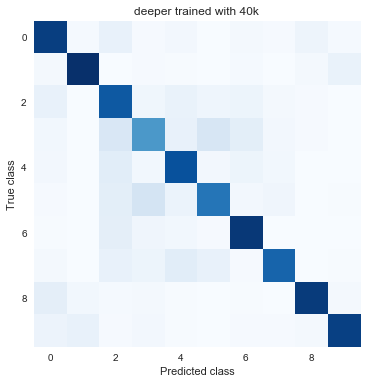

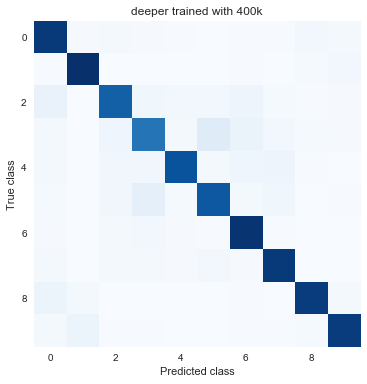

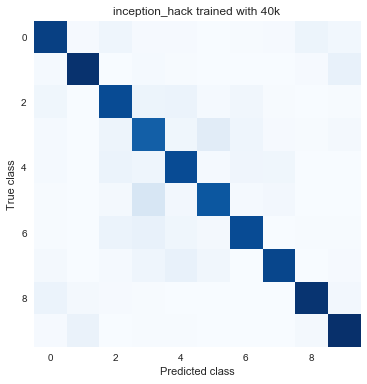

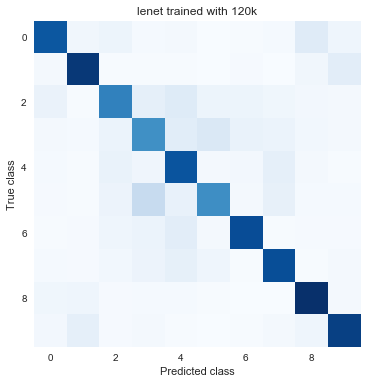

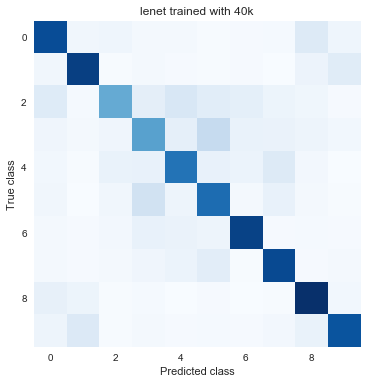

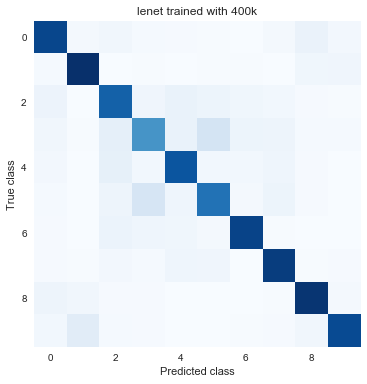

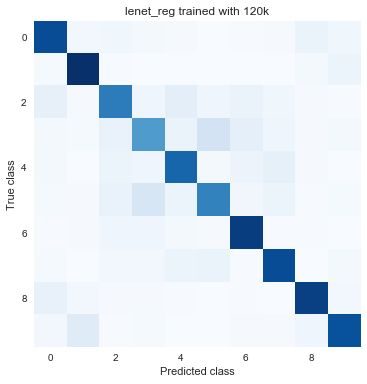

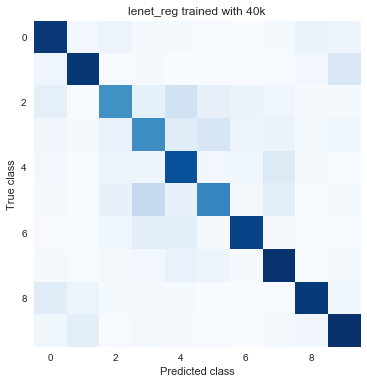

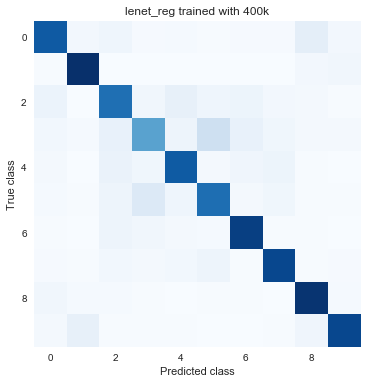

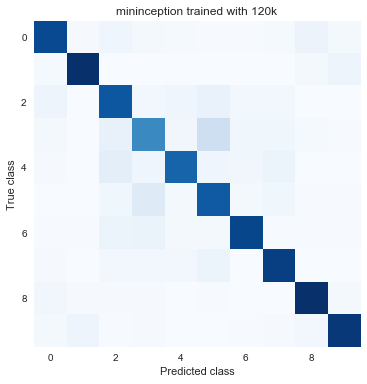

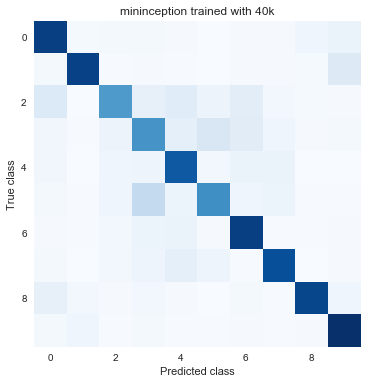

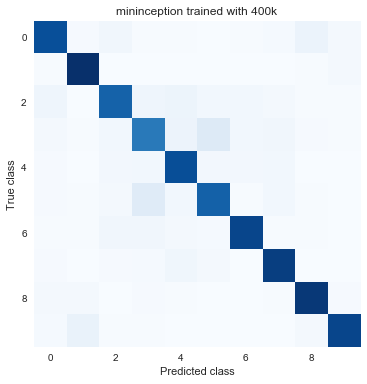

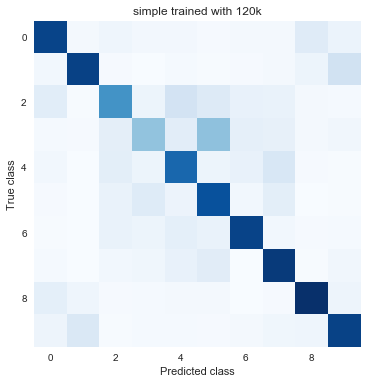

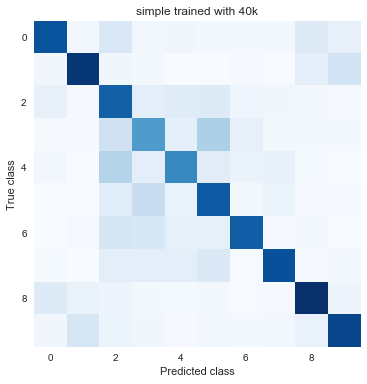

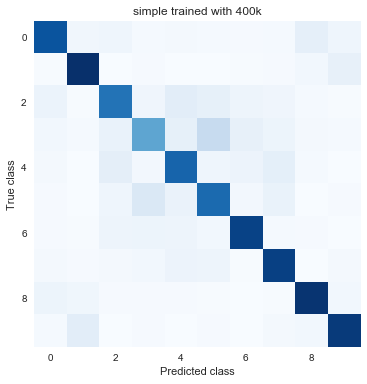

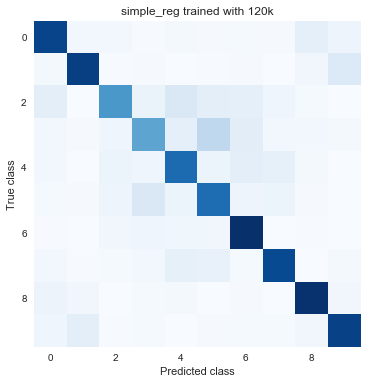

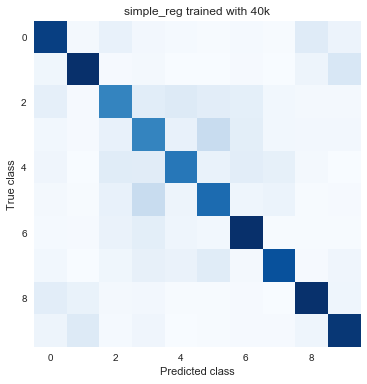

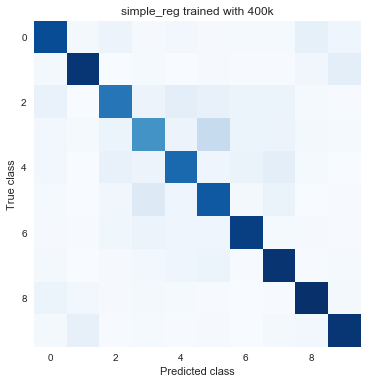

In [10]:
# Plot confusion matrix
for index, row in results.iterrows():
    y_pred = np.argmax(row['y_pred'], axis=1)
    y_true = np.argmax(row['y_true'], axis=1)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plt.imshow(cnf_matrix, cmap=plt.cm.Blues)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title('{} trained with {}k'.format(row['model'], row['size'] / 1000))
    plt.tight_layout()
    plt.grid(None)
    plt.show()

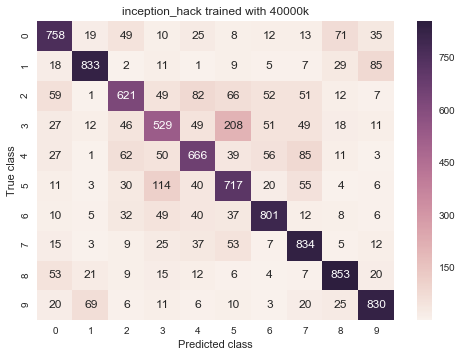

In [11]:
row = results.iloc[6]
y_pred = np.argmax(row['y_pred'], axis=1)
y_true = np.argmax(row['y_true'], axis=1)
sns.heatmap(cnf_matrix, annot=True, fmt="d")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('{} trained with {}k'.format(row['model'], row['size']))
plt.show()

In [17]:
results[['model', 'size', 'test_accuracy', 'test_loss']].sort_values('test_accuracy', ascending=False)

,model,size,test_accuracy,test_loss
5,deeper,400000,0.8552,0.477385
15,mininception,400000,0.8517,0.523120
2,deep,400000,0.8466,0.463204
6,inception_hack,40000,0.8270,0.572822
13,mininception,120000,0.8127,0.634564
3,deeper,120000,0.7939,0.639767
0,deep,120000,0.7936,0.609059
12,lenet_reg,400000,0.7883,0.613337
9,lenet,400000,0.7807,0.677672
1,deep,40000,0.7636,0.740727
